<a href="https://colab.research.google.com/github/pakdaniel/DataMiningFinal/blob/main/DataMiningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pysofaconventions
!pip3 install colorama

     |████████████████████████████████| 89 kB 3.5 MB/s 


In [2]:
import tensorflow as tf
import numpy as np 
import random
import matplotlib.pyplot as plt
import os 
import sys
import librosa
import librosa.display
import pysofaconventions 
import colorama
from warnings import warn
from IPython.display import Audio, display
from scipy import signal 

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
from google.colab import drive
drive_root = '/content/drive'
drive.mount(drive_root)

HUTUBS_PATH = os.path.join(drive_root, "My Drive", "HUTUBS")
HRIR_DIR = os.path.join(HUTUBS_PATH, "HRIRs")

T3D3A_PATH = os.path.join(drive_root, "My Drive", "3D3A", "Acoustic")

Mounted at /content/drive


In [6]:
class SOFA:
  def __init__(self, obj):

    self.IR = obj.getDataIR().data
    self.SamplingRate = obj.getSamplingRate().data.item()
    self.SamplingRateUnits = obj.getSamplingRateUnits()
    self.Delay = obj.getDataDelay().data
      
    dim_dict = obj.getDimensionsAsDict()
    self.M = dim_dict["M"].size # Num measurement positions
    self.R = dim_dict["R"].size # Num receivers (ears)
    self.E = dim_dict["E"].size # Num emitters (speakers)
    self.N = dim_dict["N"].size # Length of HRTF
    self.I = dim_dict["I"].size 
    self.S = dim_dict["S"].size

    self.Listener = {
        "Position": obj.getListenerPositionValues().data,
        "PositionType": obj.getListenerPositionInfo()[1],
        "PositionUnits": obj.getListenerPositionInfo()[0],
        "Up": obj.getListenerUpValues().data,
        "View": obj.getListenerViewValues().data,
        "ViewType": obj.getListenerViewInfo()[1],
        "ViewUnits": obj.getListenerViewInfo()[0],
    }

    self.Receiver = {
        "Position": obj.getReceiverPositionValues().data,
        "PositionType": obj.getReceiverPositionInfo()[1],
        "PositionUnits": obj.getReceiverPositionInfo()[0],
    }

    self.Source = {
        "Position": obj.getSourcePositionValues().data,
        "PositionType": obj.getSourcePositionInfo()[1],
        "PositionUnits": obj.getSourcePositionInfo()[0],
    }

    self.Emitter = {
        "Position": obj.getEmitterPositionValues().data,
        "PositionType": obj.getEmitterPositionInfo()[1],
        "PositionUnits": obj.getEmitterPositionInfo()[0],
    }

  @staticmethod
  def sph2cart(coords):
      alpha = coords[:, 0]*(np.pi/180)
      beta = coords[:, 1]*(np.pi/180)
      r = coords[:, 2]

      x = r * np.cos(alpha) * np.cos(beta)
      y = r * np.sin(alpha) * np.cos(beta)
      z = r * np.sin(beta)
      return np.array([x, y, z]).T

  @staticmethod
  def cart2sph(coords):
      x = coords[:, 0]
      y = coords[:, 1]
      z = coords[:, 2]
      
      r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
      alpha = np.arctan2(y, x)
      beta = np.arcsin(z / np.where(r != 0, r, 1))
      return alpha, beta, r

  def split_HRIR_by_location(self, azimuth, elevation):
      outputs = self.IR[np.all(self.Source["Position"][:, :2] == np.array([azimuth, elevation]), axis=1)], self.IR[np.any(self.Source["Position"][:, :2] != np.array([azimuth, elevation]), axis=1)]
      if len(outputs[0]) == 0:
          raise ValueError("The given (azimuth, elevation) angle pair does not exist in the HRIR")
      return outputs

  def split_HRIR_by_locations(self, locations):

      conditions = np.logical_or.reduce([np.all(self.Source["Position"][:, :2] == np.array([azimuth, elevation]), axis=1) for azimuth, elevation in locations])
      if not any(conditions):
          raise Exception("None of the angle pairs passed in exist in the dataset")
      if sum(conditions) != len(locations):
          warn("One or more of the angle pairs passed in does not exist in the dataset; the size of the split will be smaller than the number of locations passed in.")
      outputs = self.IR[conditions], self.IR[~conditions]
      return outputs

  def get_indices_of_locations(self, locations):
      if type(locations) == tuple and len(locations) == 2:
          locations = [locations]
      return np.where(np.logical_or.reduce([np.all(self.Source["Position"][:, :2] == np.array([azimuth, elevation]), axis=1) for azimuth, elevation in locations]) == True)[0]

def playback(audiofile_path):
  Audio(audiofile_path)

def read_sofa(sofa_path):
  return SOFA(pysofaconventions.SOFAFile(sofa_path,'r'))

In [18]:
subject_exclude = [3, 5, 6, 7, 8, 9] # these subjects don't exist in 3D3A database

hrir_paths = []
for i in range(1,44+1):
  if i not in subject_exclude:
    var = "Subject" + str(i)
    temp_path = os.path.join(T3D3A_PATH, var, var+"_HRIRs.sofa")
    hrir_paths.append(temp_path)

hrir_all = [read_sofa(i) for i in hrir_paths]

assert len(hrir_all) == 38, "There should only be 38 subjects"

In [60]:
# THESE ARE FIXED PARAMETERS USED BY 3D3A! MUST NOT BE CHANGED!
sr = 96000 # sampling frequency/sampling rate in Hz
fs = sr
dt = 1/sr
N = 2048 # number of samples
t = np.arange(N)*dt

In [122]:
test = hrir_all[0]
y = test.IR[0][0]

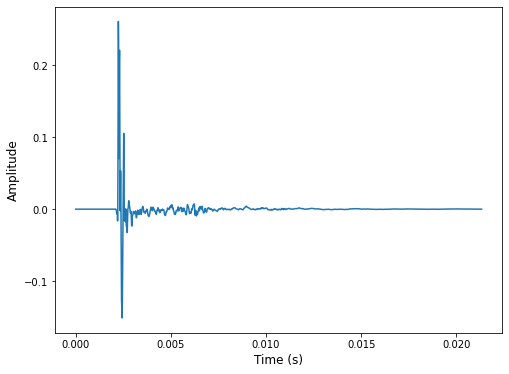

In [123]:
plt.figure(figsize=(8,6))
plt.plot(t, y)
plt.xlabel("Time (s)", fontsize = 12)
plt.ylabel("Amplitude", fontsize = 12)
# plt.ylim([-1,1])
plt.show()

(129, 15)
(129,)
(15,)


Text(0, 0.5, 'Frequency')

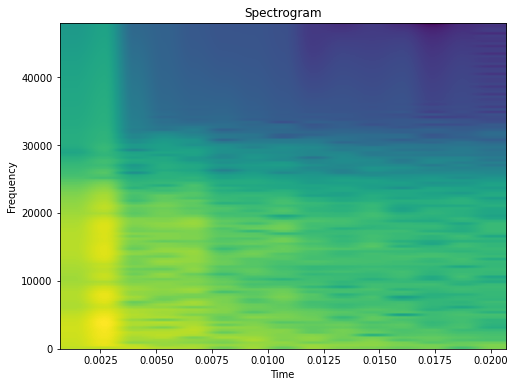

In [124]:
plt.figure(figsize=(8,6))
plt.title('Spectrogram')    
Pxx, freqs, bins, im = plt.specgram(y,Fs=fs,NFFT=256)

print(Pxx.shape)
print(freqs.shape)
print(bins.shape)

plt.xlabel('Time')
plt.ylabel('Frequency')

In [125]:
hop_length = 64 # length of the non-intersecting portion of window length
n_fft = 1024 # how many FFT points in window
n_mels = 64 # used for mel spectrogram

(513, 33)


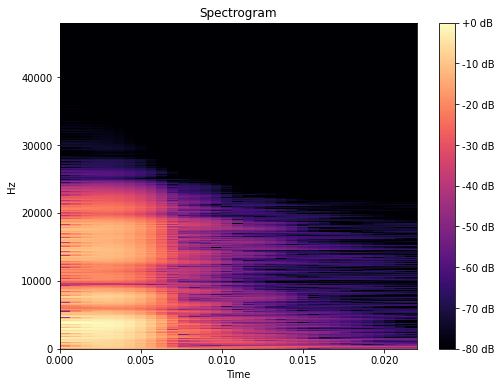

In [126]:
spec = np.abs(librosa.stft(y, hop_length=hop_length, n_fft = n_fft))
spec = librosa.amplitude_to_db(spec, ref=np.max) # converting to decibals

print(spec.shape)

# Plotting the spectrogram
plt.figure(figsize=(8,6));
librosa.display.specshow(spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

(64, 33)


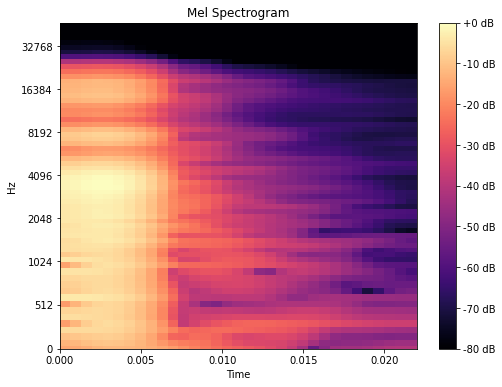

In [127]:
# Computing the mel spectrogram
mel_spec = librosa.feature.melspectrogram(y, sr = sr, hop_length=hop_length, n_fft = n_fft, n_mels=n_mels)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

print(mel_spec.shape)

# Plotting the mel spectrogram
plt.figure(figsize=(8,6))
librosa.display.specshow(mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');